In [ ]:
import sys
import pandas as pd
import numpy as np
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
imported pandas and numpy


In [34]:
# Set file directories:
outputDir = "../output"
dataDir = "../data"

# File contents
The raw data were from ../data/*
Files include:
1. UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).XLSX: Global metabolite
2. UNAZ-03-24VWCLP+ BRAIN HEATMAP (CLP).XLSX
3. UNAZ-03-24VWCLP+ BRAIN HEATMAP (GLOBAL).XLSX
4. UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX
5. UNAZ-03-24VWCLP+ PLASMA DATA TABLES (GLOBAL).XLSX
6. UNAZ-03-24VWCLP+ PLASMA HEATMAP (CLP).XLSX
7. UNAZ-03-24VWCLP+ PLASMA HEATMAP (GLOBAL).XLSX
8. UNAZ-03-24VWCLP+ PLASMA SIX TAB FILE (CLP DATA).XLSX
9. UNAZ-03-24VWCLP+ REPORT_16DEC24.DOCX

From the report, "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform, therefore no additional normalization of the data was performed prior to statistical analysis". 
So this processing file only deal with the meta data, extract the normalized expressions of each metabolites

## Data processing from the report:
*Batch Normalization*: To remove batch variability, for each metabolite, the values in the experimental samples are divided by the median of those samples in each instrument batch, giving each batch and thus the metabolite a median of one.  

*Volumn Normalization*: For each sample, the Batch-normalized data is divided by the value of the normalizer. Since "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform", the value of the normalizer is 1. Then each metabolite is re-scaled to have median = 1 (divide the new values by the overall median for each metabolite). 

*Missing Value imputation*:For each metabolite, the minimum value across all batches in the median scaled data is imputed for the missing values

*log transformation*:The Batch-norm-Imputed Data (or protein, volume, etc. normalized data if applicable) is transformed using the natural log. Metabolomic data typically displays a log-normal distribution, therefore, the log-transformed data is used for statistical analyses.


# Data Processing

In [35]:
import os
# Define the data directory and file name
filename = "UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).xlsx"
filepath = os.path.join(dataDir, filename)


## Chemical names

In [5]:
# Step 1: Open the Excel file without loading the data
with pd.ExcelFile(filepath) as excel_file:
    # Step 2: Load only the column names from the sheet
    columns = pd.read_excel(excel_file, sheet_name="Chemical Annotation", nrows=0).columns

    # Step 3: Define the dtype dictionary dynamically
    dtype = {
        'CHEM_ID': int,
        'LIB_ID': int,
        'COMP_ID': int,
        'CHRO_LIB_ENTRY_ID': int,
        #"PATHWAY_SORTORDER": int,
        **{col: str for col in columns if col not in ['CHEM_ID', 'LIB_ID', 'COMP_ID', 'CHRO_LIB_ENTRY_ID', 'PATHWAY_SORTORDER']}
    }

    # Step 4: Read the full data with the correct dtype
    chemicalnames = pd.read_excel(excel_file, sheet_name="Chemical Annotation", header=0, dtype=dtype)
    
print(chemicalnames.iloc[1:5,:])


   CHEM_ID  LIB_ID  COMP_ID  CHRO_LIB_ENTRY_ID SUPER_PATHWAY  \
1       41     305     1633             145742    Amino Acid   
2       49     400     1408             155357    Amino Acid   
3       50     400      485             155305    Amino Acid   
4       71     209      437             123157    Amino Acid   

             SUB_PATHWAY  PATHWAY_SORTORDER   TYPE  \
1   Histidine Metabolism               88.0  NAMED   
2   Polyamine Metabolism              547.0  NAMED   
3   Polyamine Metabolism              555.0  NAMED   
4  Tryptophan Metabolism              297.0  NAMED   

                      INCHIKEY                         SMILES  ...  \
1  CCLQKVKJOGVQLU-UHFFFAOYSA-N  NCCCC(NC(CC1=CN=CN1)C(O)=O)=O  ...   
2  KIDHWZJUCRJVML-UHFFFAOYSA-N                         NCCCCN  ...   
3  ATHGHQPFGPMSJY-UHFFFAOYSA-N                     NCCCCNCCCN  ...   
4  DUUGKQCEGZLZNO-UHFFFAOYSA-N    OC1=CC=C(NC=C2CC(O)=O)C2=C1  ...   

                PLOT_NAME LIPID SPECIES LEVEL LIPID MOLEC

In [6]:
print(chemicalnames.columns)

Index(['CHEM_ID', 'LIB_ID', 'COMP_ID', 'CHRO_LIB_ENTRY_ID', 'SUPER_PATHWAY',
       'SUB_PATHWAY', 'PATHWAY_SORTORDER', 'TYPE', 'INCHIKEY', 'SMILES',
       'CHEMICAL_NAME', 'PLOT_NAME', 'LIPID SPECIES LEVEL',
       'LIPID MOLECULAR SPECIES LEVEL', 'LIPID SN POSITION LEVEL', 'CAS',
       'CHEMSPIDER', 'HMDB', 'KEGG', 'PUBCHEM', 'PLATFORM'],
      dtype='object')


## Sample Meta data

In [ ]:
# Step 1: Open the Excel file without loading the data
with pd.ExcelFile(filepath) as excel_file:
    

    # Step 4: Read the full data with the correct dtype
    samples = pd.read_excel(excel_file, sheet_name="Sample Meta Data", header=0, dtype=str)

samples = samples[["PARENT_SAMPLE_NAME","BOX_NUMBER","GENOTYPE","GROUP_ID","GROUP_NAME","SAMPLE_BOX_LOCATION",	"SAMPLE_DESCRIPTION",	"SAMPLE_STATUS",	"TIMEPOINT"]]    
samples = samples.loc[samples["TIMEPOINT"].notna()]
print(samples.iloc[1:5,:])

   PARENT_SAMPLE_NAME  BOX_NUMBER GENOTYPE         GROUP_ID        GROUP_NAME  \
13         UNAZ-04969  5500038776   APOE33    APOE33_6M_Reg    APOE3/3 6M-Reg   
14         UNAZ-04970  5500038776   APOE33    APOE33_9M_Reg    APOE3/3 9M-Reg   
15         UNAZ-04971  5500038776   APOE33    APOE33_9M_Reg    APOE3/3 9M-Reg   
16         UNAZ-04972  5500038776   APOE33  APOE33_9M_Irreg  APOE3/3 9M-Irreg   

   SAMPLE_BOX_LOCATION SAMPLE_DESCRIPTION SAMPLE_STATUS TIMEPOINT  
13                  D1             cortex           Reg        6M  
14                  A2             cortex           Reg        9M  
15                  D2             cortex           Reg        9M  
16                  A3             cortex         Irreg        9M  


## log normalized expression

In [14]:
with pd.ExcelFile(filepath) as excel_file:
    data = pd.read_excel(excel_file, sheet_name="Log Transformed Data", index_col=0, header=0).rename_axis(index=None, columns=None).astype(float)


print(data.iloc[1:5,1:5])

                  41        49        50        71
UNAZ-04969 -0.131976 -0.106706 -0.210293 -0.022508
UNAZ-04970  0.097819  0.167090 -0.148333 -0.236822
UNAZ-04971  0.106389  0.266844  0.100569 -0.389123
UNAZ-04972 -0.135393  0.000004 -0.008108 -0.155188


# Data visualization

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## boxplot

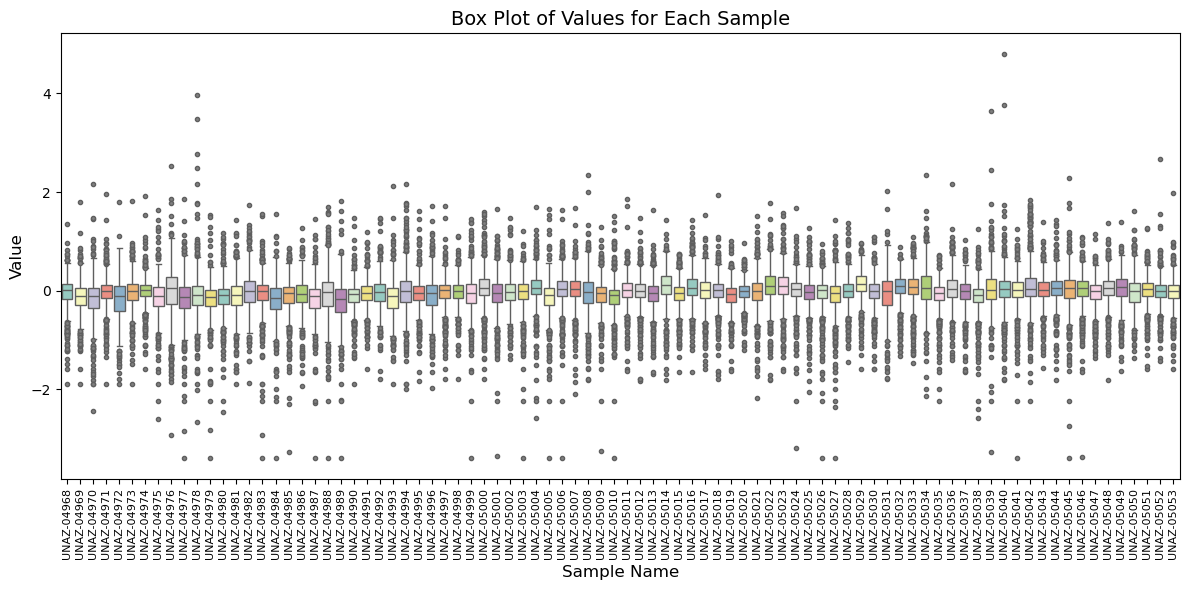

In [ ]:
data_transposed = data.T

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transposed, palette="Set3",flierprops=dict(marker='.', markerfacecolor='grey',linestyle='none'))
plt.title("Box Plot of Values for Each Sample", fontsize=14)
plt.xlabel("Sample Name", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=90,fontsize=8)  # Rotate sample names for better readability
plt.tight_layout() #Adjust the layout to prevent overlapping of labels.
plt.show()
plt.savefig()

In [29]:
samples.columns

Index(['PARENT_SAMPLE_NAME', 'BOX_NUMBER', 'GENOTYPE', 'GROUP_ID',
       'GROUP_NAME', 'SAMPLE_BOX_LOCATION', 'SAMPLE_DESCRIPTION',
       'SAMPLE_STATUS', 'TIMEPOINT'],
      dtype='object')

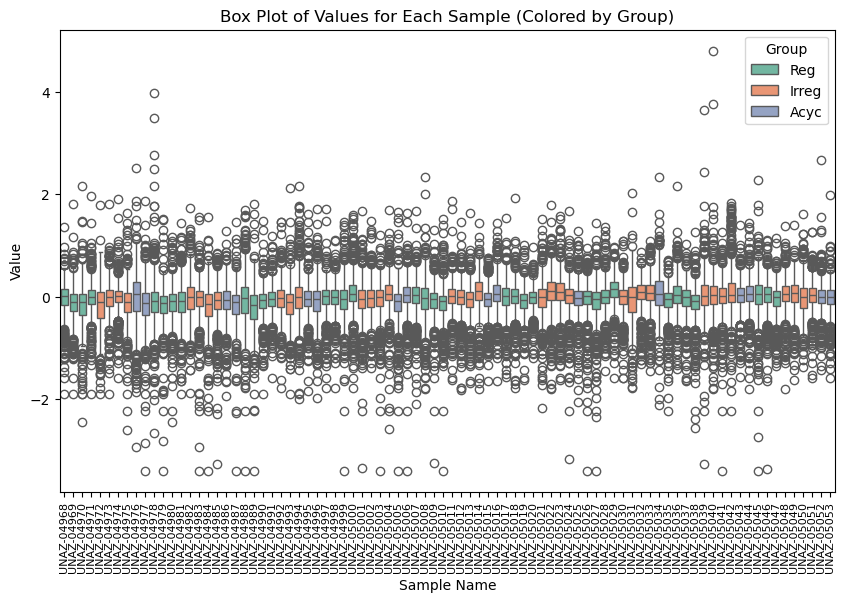

In [32]:
# Melt the data for seaborn
data_melted = data_transposed.melt(var_name="PARENT_SAMPLE_NAME", value_name="Value")

# Add group information

data_melted = data_melted.merge(samples, on="PARENT_SAMPLE_NAME", how="left")

# Create the box plot with group colors
plt.figure(figsize=(10, 6))
sns.boxplot(x="PARENT_SAMPLE_NAME", y="Value", hue="SAMPLE_STATUS", data=data_melted, palette="Set2")
plt.title("Box Plot of Values for Each Sample (Colored by Group)")
plt.xlabel("Sample Name")
plt.ylabel("Value")
plt.xticks(rotation=90,fontsize=8)
plt.legend(title="Group")
plt.show()

## PCA

In [17]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_results = pca.fit_transform(data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"], index=data.index)

# Add group information to the PCA results
# TIMEPOINT, GENOTYPE, GROUP_ID, GROUP_NAME, SAMPLE_STATUS
pca_df["group"] = pca_df.index.map(samples.set_index("PARENT_SAMPLE_NAME")["TIMEPOINT"])

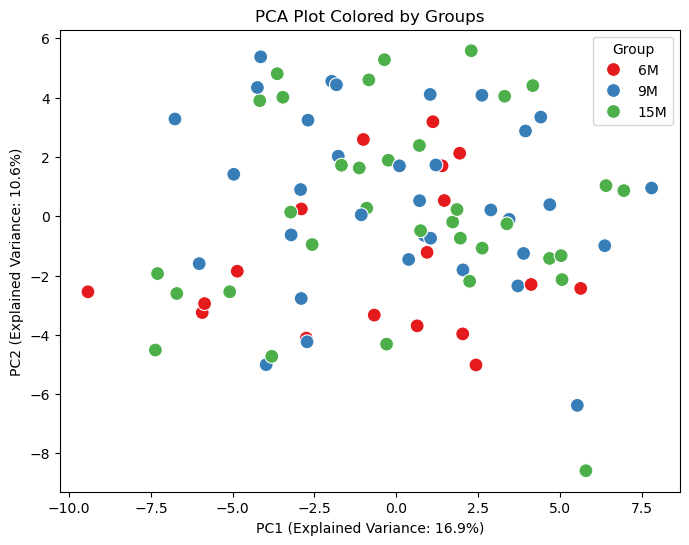

In [19]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="group", data=pca_df, palette="Set1", s=100
)
plt.title("PCA Plot Colored by Groups")
plt.xlabel(f"PC1 (Explained Variance: {100*pca.explained_variance_ratio_[0]:.1f}%)")
plt.ylabel(f"PC2 (Explained Variance: {100*pca.explained_variance_ratio_[1]:.1f}%)")
plt.legend(title="Group")
plt.show()